<div>
    <img src="images/emlyon.png" style="height:60px; float:left; padding-right:10px; margin-top:5px" />
    <span>
        <h1 style="padding-bottom:5px;"> Smart Supply Chain </h1>
        <a href="https://masters.em-lyon.com/fr/msc-in-data-science-artificial-intelligence-strategy">[Emlyon]</a> MSc in Data Science & Artificial Intelligence Strategy (DSAIS) <br/>
         January 2024, Paris | © Saeed VARASTEH
    </span>
</div>

### Part 02 : Time Series Forecasting | Statistical Models

This lecture content will be about statistical models in time series forecasting.

---

### Import data and modules

#### Import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

#### Import data

In [2]:
df = pd.read_csv('./data/international-airline-passengers.csv',header=None)
df.columns = ['year','passengers']
print(df.shape)
df.head(5)

(144, 2)


,year,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


#### Convert year column to datetime

In [3]:
df['year'] = pd.to_datetime(df['year'], format='%Y-%m')

In [4]:
df.head(5)

,year,passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


#### Set year as index

In [5]:
df.set_index('year', inplace=True, drop=True)
df.head(5)

,passengers
year,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


#### Set monthly frequency for `df`

In [6]:
df = df.asfreq('MS')
df.head()

,passengers
year,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


---

### Prepare our time series

#### Making time series stationary

In [7]:
df_log = np.log(df)
dfs = df_log - df_log.shift(1) 
dfs.dropna(inplace=True)

df_old = df.copy()
df = dfs
df.head()

,passengers
year,
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022
1949-06-01,0.109484


#### Autocorrelation and Partial autocorrelation plots

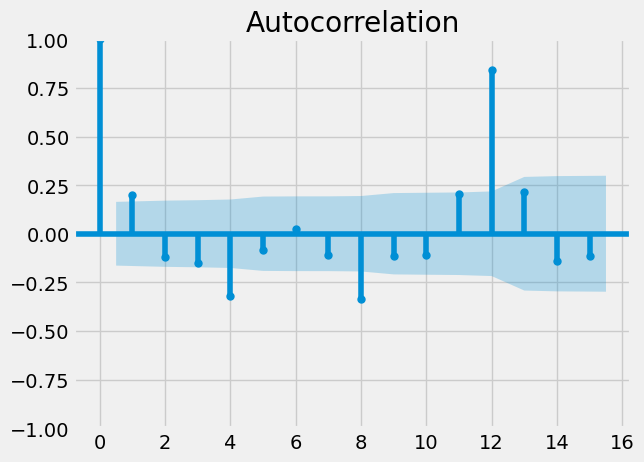

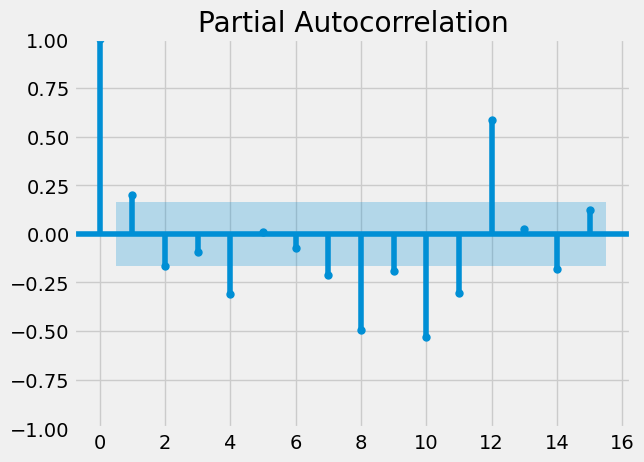

In [8]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plot_acf(df, lags = 15)
plot_pacf(df, lags = 15)
plt.show()

---

### Time series forecasting

There are many methods that we can use for time series forecasting and there is not a clear winner. Model selection should always depend on how you data look and what are you trying to achieve.

#### Split our dataset to be able to evaluate our models

In [9]:
split_date ='1959-01-01'
df_train = df.loc[df.index < split_date]
df_test = df.loc[df.index >= split_date]
print(f"{len(df_train)} months of training data and {len(df_test)} months of testing data ")

119 months of training data and 24 months of testing data 


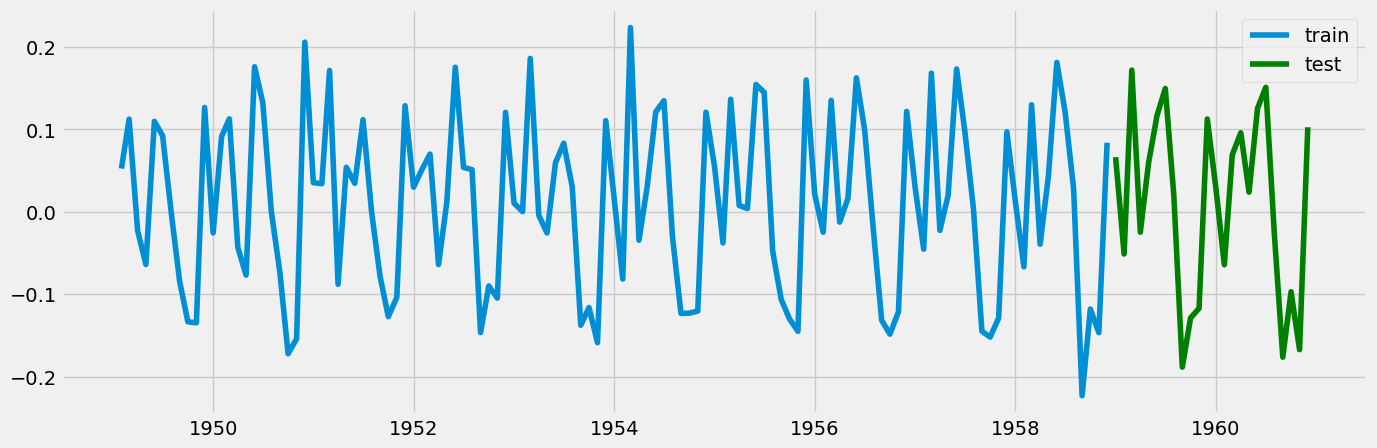

In [10]:
fig, ax = plt.subplots(1,1,figsize=(15, 5))
plt.plot(df_train, label="train");
plt.plot(df_test, label="test", color="green");
plt.legend();

### <span style="color:steelblue;"> Naive forecast </span>

In [11]:
df_mean = df_train.passengers.mean()
mean_forecast = np.array([df_mean for v in range(len(df_test))])
mean_forecast_df = pd.DataFrame(data=mean_forecast, columns=df_test.columns, index=df_test.index)

In [12]:
def plot_forecast(forecast_df,method_name):
    fig, ax = plt.subplots(1,1,figsize=(15, 5))
    plt.plot(df_train, label="train");
    plt.plot(df_test, label="test", color="green");
    plt.plot(forecast_df, label=method_name, color="red", linestyle=":");
    plt.legend();

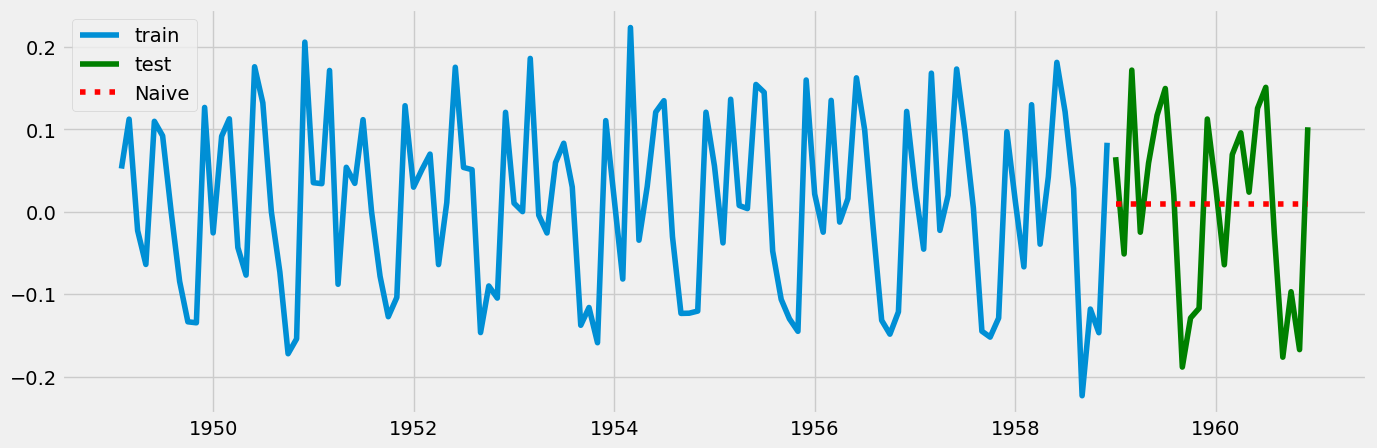

In [13]:
plot_forecast(mean_forecast_df, "Naive")

---

### Forecast quality scoring metrics

__Mean Squared Error (MSE)__, most commonly used, gives higher penalty to big mistakes and vise versa, [0, +inf).

__Mean Absolute Error (MAE)__, it is an interpretable metric because it has the same unit of measurement as the initial series, [0, +inf).

__Mean Absolute Percentage Error (MAPE)__, same as MAE but percentage, — very convenient when you want to explain the quality of the model to your management, [0, +inf).

__R squared ($R^2$)__, coefficient of determination (it can be interpreted as a percentage of variance explained by the model), (-inf, 1].

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [15]:
results_all_models = pd.DataFrame(columns=["MSE","MAE","MAPE","R2"])

def evaluate_forecast(df_test, df_pred, method_name):
    y = df_test.values
    y_pred = df_pred.values
    results = {}
    results['MSE'] = mean_squared_error(y, y_pred)
    results['MAE'] = mean_absolute_error(y, y_pred)
    results['MAPE'] = mean_absolute_percentage_error(y, y_pred)
    results['R2'] = r2_score(y, y_pred)
    
    results_df = pd.DataFrame(data=results, index=[method_name])
    global results_all_models
    results_all_models = pd.concat([results_all_models,results_df])
    print( results_all_models.head(10) )

In [16]:
evaluate_forecast(df_test, mean_forecast_df, "Naive")

            MSE       MAE      MAPE        R2
Naive  0.012093  0.095631  0.968606 -0.000098


---

### <span style="color:steelblue;"> Autoregression (AR) </span>

The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps. 

Parameters of the model:

- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be based on x(t-1)….x(t-5).


In [17]:
from statsmodels.tsa.arima.model import ARIMA

pred_ = list()
for t in range(len(df_test.passengers)):
    temp_train = df[:len(df_train)+t]
    model = ARIMA(temp_train.passengers, order=(1, 0, 0))
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    pred_ = pred_ + [predictions]
    
ar_forecast_df = pd.concat(pred_)

/Users/fulin/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/fulin/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


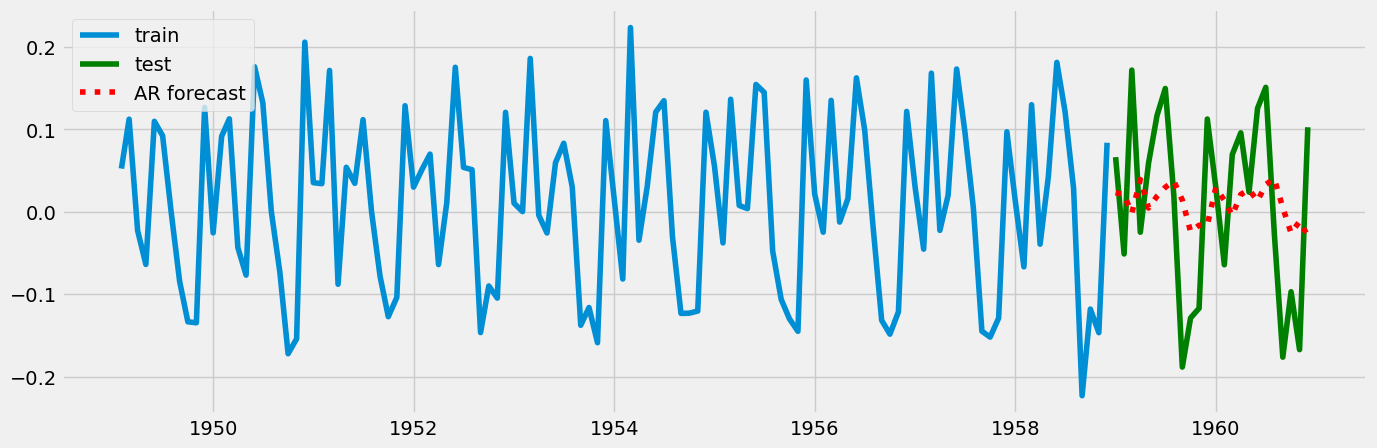

In [18]:
plot_forecast(ar_forecast_df, "AR forecast")

In [19]:
evaluate_forecast(df_test, ar_forecast_df, "AR")

            MSE       MAE      MAPE        R2
Naive  0.012093  0.095631  0.968606 -0.000098
AR     0.011422  0.093425  1.013236  0.055373


### <span style="color:steelblue;"> Moving Average (MA) </span>

The Moving Average (MA) method models the next step in the sequence as the average of a window of observations at prior time steps. 

Parameters of the model:

- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be based on e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value. 


In [20]:
from statsmodels.tsa.arima.model import ARIMA

pred_ = list()
for t in range(len(df_test.passengers)):
    temp_train = df[:len(df_train)+t]
    model = ARIMA(temp_train.passengers, order=(0, 0, 1))
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    pred_ = pred_ + [predictions]
    
ma_forecast_df = pd.concat(pred_)

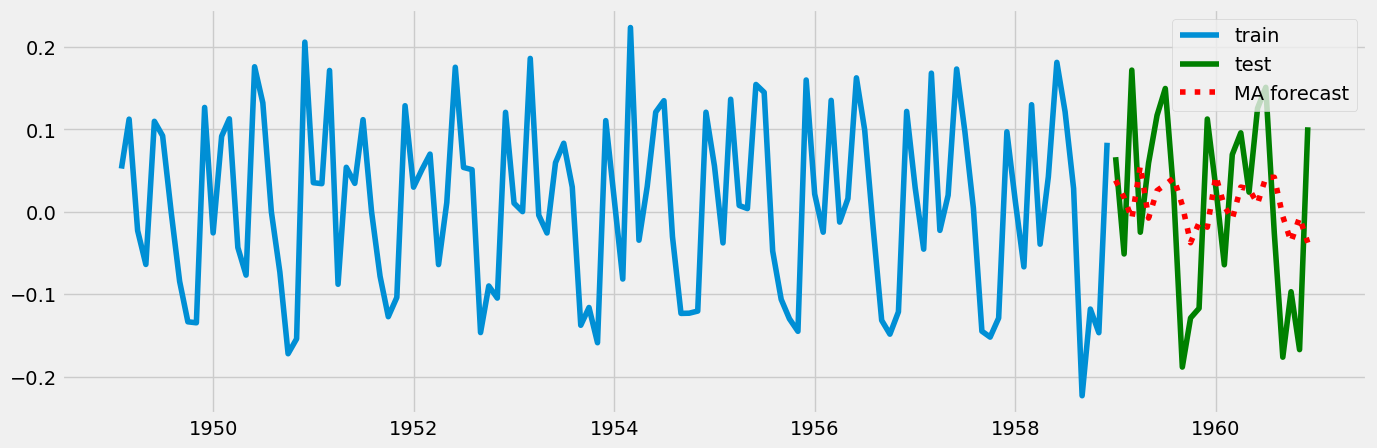

In [21]:
plot_forecast(ma_forecast_df, "MA forecast")

In [22]:
evaluate_forecast(df_test, ma_forecast_df, "MA")

            MSE       MAE      MAPE        R2
Naive  0.012093  0.095631  0.968606 -0.000098
AR     0.011422  0.093425  1.013236  0.055373
MA     0.011230  0.092973  1.054941  0.071244


### <span style="color:steelblue;"> Autoregressive Moving Average (ARMA) </span>

This method will basically join the previous two `AR` and `MA`. Model parameters will be the sum of the two.

Parameters of the model:

- __Number of AR (Auto-Regressive) terms (p)__ 
- __Number of MA (Moving Average) terms (q)__ 

In [23]:
from statsmodels.tsa.arima.model import ARIMA

pred_ = list()
for t in range(len(df_test.passengers)):
    temp_train = df[:len(df_train)+t]
    model = ARIMA(temp_train.passengers, order=(1, 0, 1))
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    pred_ = pred_ + [predictions]
    
arma_forecast_df = pd.concat(pred_)

/Users/fulin/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


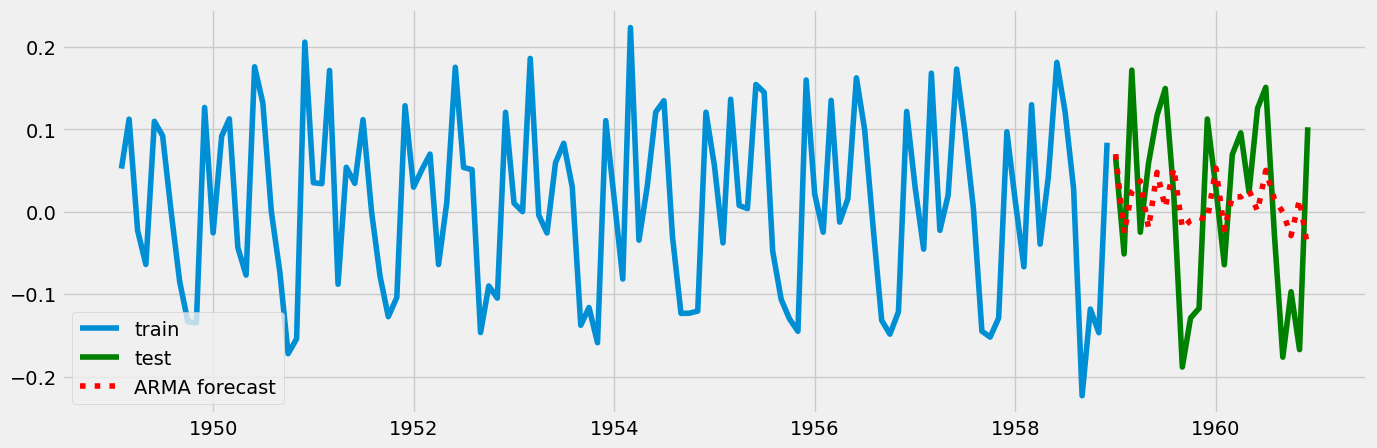

In [24]:
plot_forecast(arma_forecast_df, "ARMA forecast")

In [25]:
evaluate_forecast(df_test, arma_forecast_df, "ARMA")

            MSE       MAE      MAPE        R2
Naive  0.012093  0.095631  0.968606 -0.000098
AR     0.011422  0.093425  1.013236  0.055373
MA     0.011230  0.092973  1.054941  0.071244
ARMA   0.010713  0.088283  0.953256  0.114001


### <span style="color:steelblue;">  Autoregressive integrated Moving Average (ARIMA)  </span>

In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. 

These parameters are labeled p,d,and q:

* __Number of AR (Auto-Regressive) terms (p)__

* __Number of Differences (d):__ d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.

* __Number of MA (Moving Average) terms (q)__

<div class="alert-warning">
Note: A problem with ARIMA is that it does not support seasonal data. That is a time series with a repeating cycle. ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.
</div>

In [26]:
from statsmodels.tsa.arima.model import ARIMA

pred_ = list()
for t in range(len(df_test.passengers)):
    temp_train = df[:len(df_train)+t]
    model = ARIMA(temp_train.passengers, order=(1, 0, 1))
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    pred_ = pred_ + [predictions]
    
arima_forecast_df = pd.concat(pred_)

/Users/fulin/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


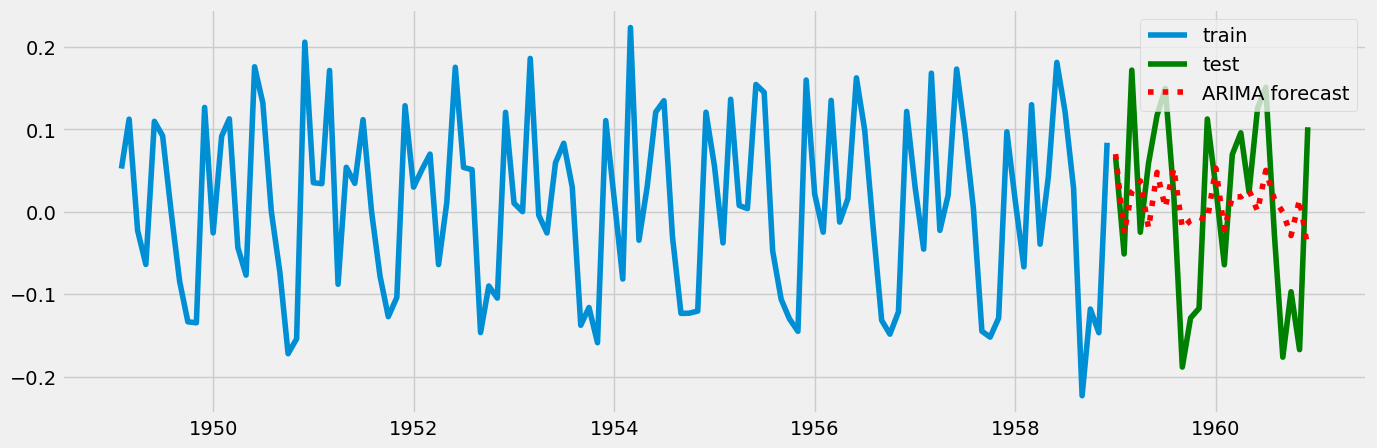

In [27]:
plot_forecast(arima_forecast_df, "ARIMA forecast")

In [28]:
evaluate_forecast(df_test, arima_forecast_df, "ARIMA")

            MSE       MAE      MAPE        R2
Naive  0.012093  0.095631  0.968606 -0.000098
AR     0.011422  0.093425  1.013236  0.055373
MA     0.011230  0.092973  1.054941  0.071244
ARMA   0.010713  0.088283  0.953256  0.114001
ARIMA  0.010713  0.088283  0.953256  0.114001


### <span style="color:steelblue;">  Seasonal Autoregressive Integrated Moving-Average (SARIMA)  </span>

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

__Trend Elements:__

There are three trend elements that require configuration. They are the same as the ARIMA model, specifically:

- p: Trend autoregression order.
- d: Trend difference order.
- q: Trend moving average order.

__Seasonal Elements:__

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period. For example, an S of 12 for monthly data suggests a yearly seasonal cycle.

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

pred_ = list()
for t in range(len(df_test.passengers)):
    temp_train = df[:len(df_train)+t]
    model = SARIMAX(temp_train.passengers, order=(1, 0, 1), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    pred_ = pred_ + [predictions]
    
sarima_forecast_df = pd.concat(pred_)

/Users/fulin/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/fulin/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/fulin/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/fulin/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/fulin/anaconda3/lib/python3.11/site-packages/statsmodels/

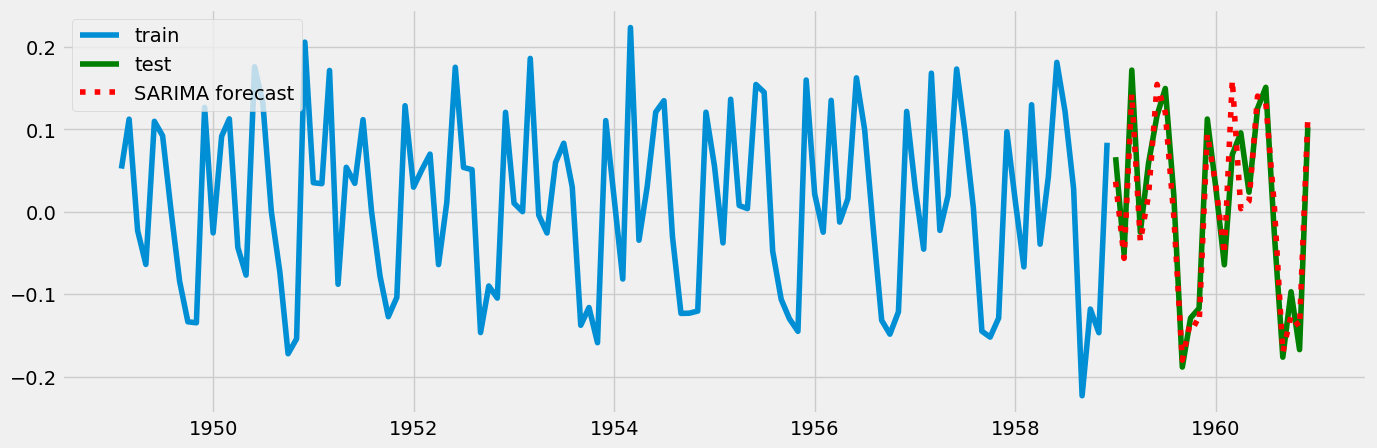

In [30]:
plot_forecast(sarima_forecast_df, "SARIMA forecast")

In [31]:
evaluate_forecast(df_test, sarima_forecast_df, "SARIMA")

             MSE       MAE      MAPE        R2
Naive   0.012093  0.095631  0.968606 -0.000098
AR      0.011422  0.093425  1.013236  0.055373
MA      0.011230  0.092973  1.054941  0.071244
ARMA    0.010713  0.088283  0.953256  0.114001
ARIMA   0.010713  0.088283  0.953256  0.114001
SARIMA  0.001144  0.025206  0.383192  0.905410


---

<div class="alert-danger">
To test the Exponential Smoothing methods, we come back to the original series.
</div>

In [32]:
df = df_old
df_train = df.loc[df.index < split_date]
df_test = df.loc[df.index >= split_date]
print(f"{len(df_train)} months of training data and {len(df_test)} months of testing data ")

120 months of training data and 24 months of testing data 


---

### <span style="color:steelblue;">  Simple Exponential Smoothing (SES) </span>

The Simple Exponential Smoothing (SES) method models the next time step as an exponentially weighted linear function of observations at prior time steps.

In [33]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

pred_ = list()
for t in range(len(df_test.passengers)):
    temp_train = df[:len(df_train)+t]
    model = SimpleExpSmoothing(temp_train.passengers)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    pred_ = pred_ + [predictions]
    
ses_forecast_df = pd.concat(pred_)

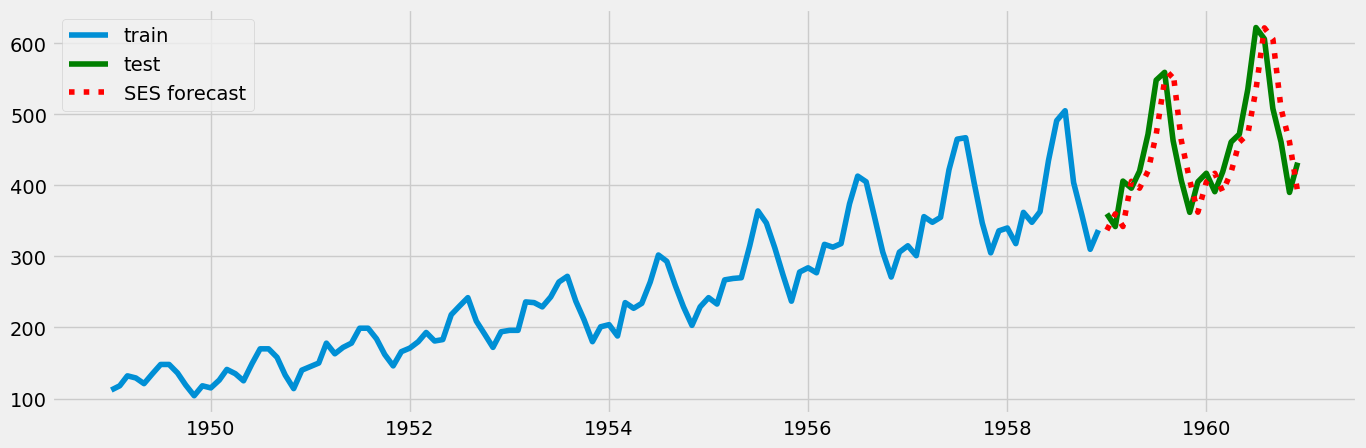

In [34]:
plot_forecast(ses_forecast_df, "SES forecast")

In [35]:
evaluate_forecast(df_test, ses_forecast_df, "SES")

                MSE        MAE      MAPE        R2
Naive      0.012093   0.095631  0.968606 -0.000098
AR         0.011422   0.093425  1.013236  0.055373
MA         0.011230   0.092973  1.054941  0.071244
ARMA       0.010713   0.088283  0.953256  0.114001
ARIMA      0.010713   0.088283  0.953256  0.114001
SARIMA     0.001144   0.025206  0.383192  0.905410
SES     2687.252893  44.237517  0.097348  0.518127


### <span style="color:steelblue;">  Holt Winter’s Exponential Smoothing (HWES) </span>

HWES also known as triple exponential smoothing.

In [36]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

pred_ = list()
for t in range(len(df_test.passengers)):
    temp_train = df[:len(df_train)+t]
    model = ExponentialSmoothing(temp_train.passengers, seasonal_periods = 12, trend='additive', seasonal='additive')
    model_fit = model.fit(optimized=True)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    pred_ = pred_ + [predictions]
    
hwes_forecast_df = pd.concat(pred_)

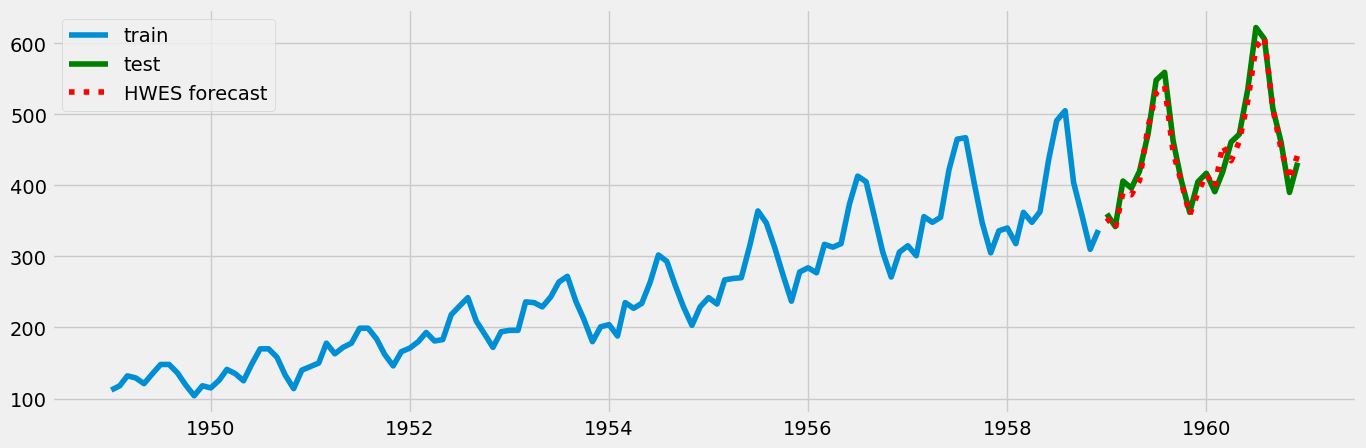

In [37]:
plot_forecast(hwes_forecast_df, "HWES forecast")

In [38]:
evaluate_forecast(df_test, hwes_forecast_df, "HWES")

                MSE        MAE      MAPE        R2
Naive      0.012093   0.095631  0.968606 -0.000098
AR         0.011422   0.093425  1.013236  0.055373
MA         0.011230   0.092973  1.054941  0.071244
ARMA       0.010713   0.088283  0.953256  0.114001
ARIMA      0.010713   0.088283  0.953256  0.114001
SARIMA     0.001144   0.025206  0.383192  0.905410
SES     2687.252893  44.237517  0.097348  0.518127
HWES     233.922466  12.378482  0.027171  0.958054


---

<div class="alert-info" style="background-color:#ece4f5;">
    <span style="font-weight:bold; color:#8966b0;">
        <h4 style="padding-top:4px; padding-bottom:4px"> EXERCISES 01 - TRY IT YOURSELF </h4>
    </span>
</div>

---